In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from jupyter_helpers import *
from helpers import *

In [ ]:
bs = 512

arch = 'resnet18'
# arch = 'levit_256'
# arch = 'levit_384'

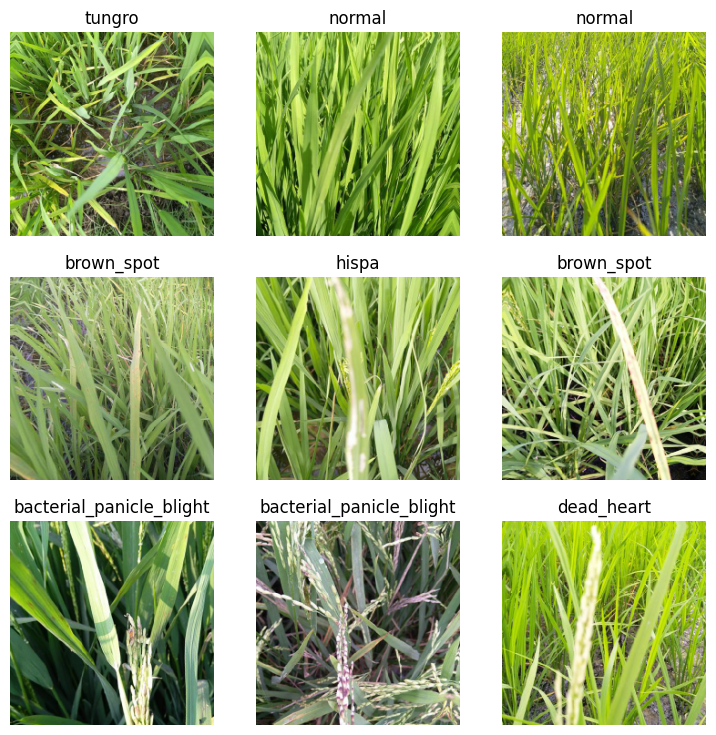

In [ ]:
dls = get_image_dls(bs)
dls.show_batch()

In [ ]:
learn = vision_learner(dls, arch, metrics=[accuracy], cbs=[ToDeviceCallback()])

epoch,train_loss,valid_loss,accuracy,time
0,2.401582,2.216489,0.454109,02:54
1,1.740222,1.906134,0.478616,03:03
2,1.416917,0.880785,0.710235,02:51
3,1.218324,0.689376,0.778952,02:46


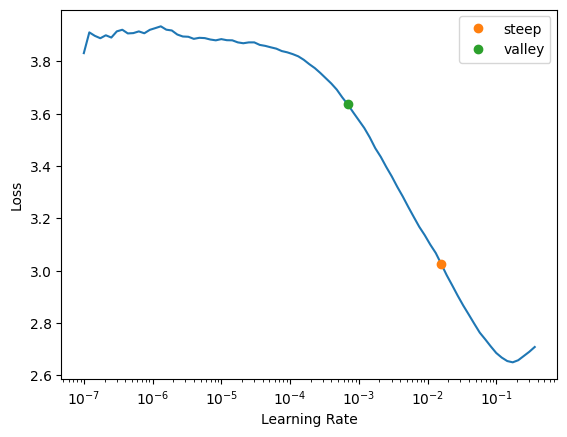

In [ ]:
with gpu_mem_restore_ctx():
    learn.model.to(device)
    
    lr_steep, lr_valley = learn.lr_find(suggest_funcs=(steep, valley))
    lr = lr_steep
    
    learn.fit_one_cycle(4, lr)

In [ ]:
with gpu_mem_restore_ctx():
    learn.fit_one_cycle(4, lr * 1.25)

epoch,train_loss,valid_loss,accuracy,time
0,0.882752,0.815449,0.728976,03:27
1,0.887882,0.839865,0.722249,02:47
2,0.855280,0.665265,0.775589,02:37
3,0.810995,0.552636,0.818837,02:39


In [ ]:
model_save_name = 'image_only__resnet18'
learn.save(model_save_name)

Path('models/image_only__resnet18.pth')

# Get embeddings

In [ ]:
learn.load(model_save_name)
preds, targs = learn.get_preds()

In [ ]:
preds.shape, targs.shape

(torch.Size([2081, 10]), torch.Size([2081]))

In [ ]:
import matplotlib.cm as cm

def plot_scatter(df):
    colors = cm.rainbow(np.linspace(0, 1, len(df.target.unique())))
    fig, ax = plt.subplots()
    for targ in df.target.unique():
        curr_df = df[df.target == targ]
        ax.scatter(curr_df.comp1, curr_df.comp2, color=colors[targ], label=dls.vocab[targ])
    ax.legend(loc="lower right")
    plt.show()

# PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
comps = pca.fit_transform(preds)
df = pd.DataFrame(data=comps, columns=['comp1', 'comp2'])
df['target'] = targs
df.head()

,comp1,comp2,target
0,-0.085898,0.089207,2
1,0.825730,0.028180,8
2,-0.084925,-0.079460,9
3,-0.364879,-0.476633,3
4,0.749456,0.021455,8


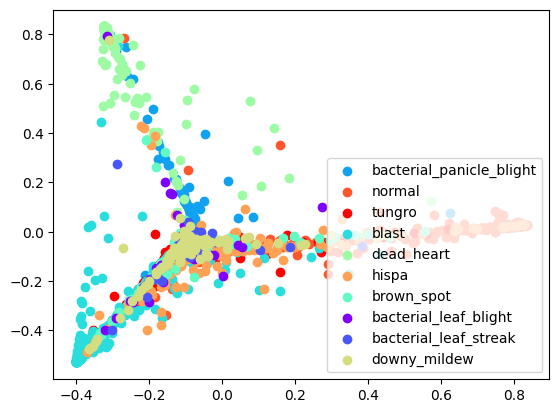

In [ ]:
plot_scatter(df)

# tSNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)
X_embedded = tsne.fit_transform(preds)
X_embedded.shape

(2081, 2)

In [ ]:
df = pd.DataFrame(data=X_embedded, columns=['comp1', 'comp2'])
df['target'] = targs
df.head()

,comp1,comp2,target
0,0.557452,106.934654,2
1,55.811279,-17.704842,8
2,33.809677,-62.471573,9
3,-46.739040,-63.433266,3
4,7.187130,63.760937,8


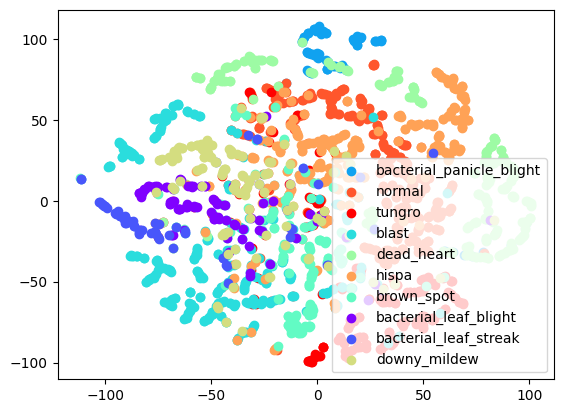

In [ ]:
plot_scatter(df)